# Calculate Generality for Secondary Amine Catalysts

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import umap
import numpy as np

import common_functions

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14

/Users/isaiahbetinol/opt/anaconda3/envs/amine_generality/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../results/iminium_VS_xgb.csv')


In [3]:
# Remove linear aldehydes with HE

carbonyl_numbers = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 128, 132, 133, 134, 135, 136, 137
]
pattern = '|'.join([f'carbonyl {n}' for n in carbonyl_numbers])
linear_aldehydes = df['Reaction Component Engages in Enamine and Iminium Formation'].str.fullmatch(pattern, na=False)
has_he = df['Reactant'].str.fullmatch('HE')

remove_idx = linear_aldehydes*has_he

df = df[~remove_idx]
df = df.reset_index(drop=True)

### Step 1: Cluster reactions

In [4]:
reduced_df = df[df['Secondary Amine'] == 'amine 2']

cluster_pipe = Pipeline([('vt',VarianceThreshold()), ('scaler',StandardScaler()), ('umap',umap.UMAP(random_state=25,
    min_dist=0,  # Default is 0.1
    n_neighbors=len(reduced_df)-1,  # Default is 15
    n_components=10))])

X = reduced_df.iloc[:,5:21]

cluster_embedding = cluster_pipe.fit_transform(X)

range_, inertia = common_functions.get_clusters(cluster_embedding,100)


/Users/isaiahbetinol/opt/anaconda3/envs/amine_generality/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
## Silhouette Analysis ##
silhouette_vals = []
num_clusters = range(2,100)

for cluster in num_clusters:
    kmeans = KMeans(
        init="k-means++",
        n_clusters=cluster,
        n_init=10,
        max_iter=300,
        random_state=25
        )
    clustering = kmeans.fit(cluster_embedding)
    silhouette_vals.append(silhouette_score(cluster_embedding,clustering.labels_))



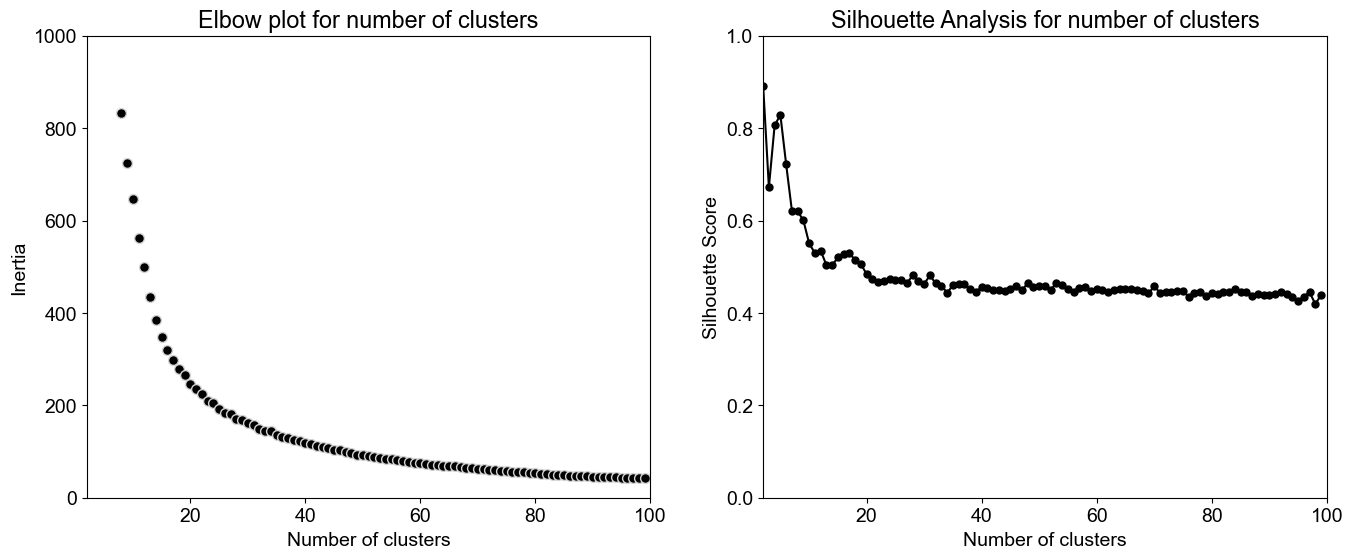

In [6]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].scatter(range_,inertia, c='black', edgecolors='lightgrey',s=50)
ax[0].set_ylim(0,1000)
ax[0].set_xlim(2,100)
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Elbow plot for number of clusters')

ax[1].plot(num_clusters, silhouette_vals, marker='o', color='black', markersize=5)
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Analysis for number of clusters')
ax[1].set_ylim(0,1)
ax[1].set_xlim(2,100)

plt.show()

In [7]:
labels = common_functions.k_cluster(cluster_embedding, 30)
full_labels = np.tile(labels,len(df['Secondary Amine'].unique()))

## Step 2: Obtain Generality Scores

maximum standard deviation at 90.0


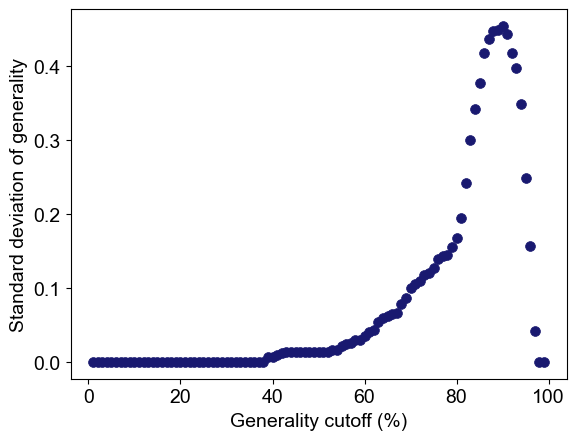

In [8]:
# 1. Convert DDG to ee
df['ee'] = common_functions.ddg2ee(df['DDG'], 273.15)

cats = df['Secondary Amine'].unique()

# 2. Calculate std deviation for generality at different cutoffs

std_list = []
thres_list = []

for threshold in np.divide(range(1,100),1):
    thres_list.append(threshold)

    cat_list = []
    gen_list = []
    cluster_list = []
    cluster_ee_list = []
    avg_ee_list = []

    for cat in cats:
        generality, clusters, cluster_ee = common_functions.calc_generality(df,cat,'Secondary Amine','ee', full_labels, threshold)
        cat_list.append(cat)
        gen_list.append(generality)
        cluster_list.append(clusters)
        cluster_ee_list.append(cluster_ee)
        avg_ee_list.append(common_functions.average_ee(cat,'Secondary Amine',df, ee_name='ee'))

    std_list.append(np.std(gen_list))
    
print(f'maximum standard deviation at {thres_list[np.argmax(std_list)]}')
print('========================')
plt.scatter(np.divide(range(1,100),1),std_list, c='midnightblue', linewidths=0.5,s=50)
plt.xlabel('Generality cutoff (%)')
plt.ylabel('Standard deviation of generality')
plt.show()


In [11]:
cat_list = []
gen_list = []
cluster_list = []
cluster_ee_list = []
avg_ee_list = []

for cat in cats:
    generality, clusters, cluster_ee = common_functions.calc_generality(df,cat,'Secondary Amine','ee', full_labels, 95)
    cat_list.append(cat)
    gen_list.append(generality)
    cluster_list.append(clusters)
    cluster_ee_list.append(cluster_ee)
    avg_ee_list.append(common_functions.average_ee(cat,'Secondary Amine',df, ee_name='ee'))



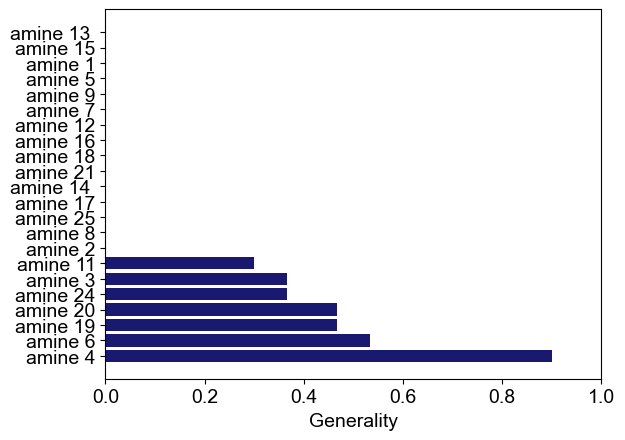

In [12]:
plot_df = pd.DataFrame({'Secondary Amine':cat_list, 'Generality':gen_list, 'Number of clusters':cluster_list, 'Cluster ee':cluster_ee_list, 'Average ee':avg_ee_list})
# plot_df = plot_df[plot_df['Generality'] > 0] # Uncomment to remove amines with no generality
plot_df.sort_values('Generality', ascending=False, inplace=True)
plot_df = plot_df.reset_index(drop=True)
plt.barh(plot_df['Secondary Amine'], plot_df['Generality'], color='midnightblue')
plt.xlim(0,1)
plt.xlabel('Generality')
plt.show()

plot_df.to_csv('../results/amine_generality.csv', index=False)

## Test different random seeds

In [13]:
## Impact of Random Seed on Generality ##
random_seed_list = []
cat_list = []
gen_list = []

for i in range(1,1000):
    labels = common_functions.k_cluster(cluster_embedding,30,random_state=i)


    for cat in cats:
        generality, clusters, cluster_ee = common_functions.calc_generality(df,cat,'Secondary Amine','ee', full_labels, 95)
        cat_list.append(cat)
        gen_list.append(generality)


# random_seed_generality = pd.DataFrame({'catalyst':cat_list,'generality':gen_list})
# random_seed_generality = random_seed_generality.set_index('catalyst')

In [14]:
cats = []
means = []
stds = []
for cat in np.unique(cat_list):
    idx_list = [idx for idx, catalyst in enumerate(cat_list) if catalyst == cat]
    mean_gen = np.mean([gen_list[idx] for idx in idx_list])
    std_gen = np.std([gen_list[idx] for idx in idx_list])
    cats.append(cat)
    means.append(mean_gen)
    stds.append(std_gen)



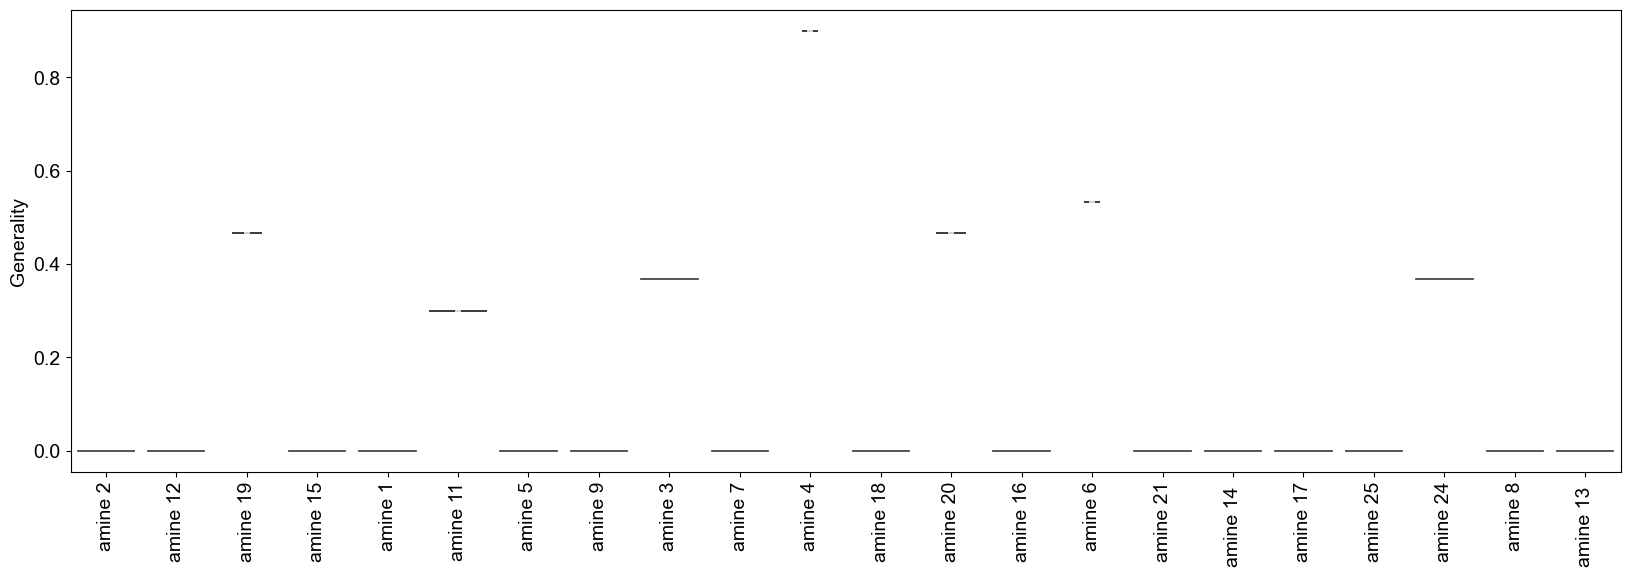

In [15]:
import seaborn as sns

plt.figure(figsize=(20,6))
sns.violinplot(x=cat_list, y=gen_list)
plt.xticks(rotation=90)
plt.ylabel('Generality')
plt.show()